# [US Mass Shootings - The Numbers](/us-mass-shootings)
<br>

<center>
<img src='http://wallpapers.ae/wp-content/uploads/2016/08/203-Assault-Rifle-HD-Picture-1600x900.jpg' style="height:300px" />
</center>

<br>

Politics are divisive. We don't need a large dataset to prove that. But the data that is out there shows both sides of the US political spectrum support some form of increased vigilance when it comes to gun rights and laws, yet nothing happens. There have been countless studies of the issues on all sides: the practical, the logistic, cultural, revolutionary, constitutional, and the need for personal defense... but I wanted to look at the numbers myself. Numbers are hard to come by though. The gun lobby has prevented the CDC from collecting research on gun violence. There is no national gun registry where a data scientist might collect meta data on who gun owners are and their reasons, or even more simply how many there are. That said, I came across a [data set](https://www.kaggle.com/zusmani/us-mass-shootings-last-50-years) of mass shootings in the US. Here is what I found.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import calendar

%matplotlib inline

In [2]:
df = pd.read_csv('data/Mass Shootings Dataset.csv',encoding = "ISO-8859-1", parse_dates=["Date"])

In [3]:
def fix_columns(col):
    return str(col).replace(' ','_').lower()

df.columns = map(fix_columns,df.columns)

df['num_shootings'] =1 

In [4]:
#when is the midpoint for the number of total shootings?
total = df.set_index('date').sort_index()[['total_victims','fatalities','num_shootings']].cumsum()

In [5]:
mask = total.num_shootings >= .5*total.num_shootings.max()
df1 = total[~mask]
t_h = df1.index[-1]
#df[['total_victims','fatalities','num_shootings']].sum()

<br>
### All trends increasing

from August 1966 through early October 2017, there have been 398 mass shootings. These are shootings where at 4 or more people were killed or injured. Tragically, almost 2000 people have died in this method, and more then double, 4,352, have been killed or injured. More alarming is the trend at which these shootings are happening, from September 2012 to October 2017 roughly half of all the mass shootings have occurred. That is, the last five years have seen as many mass shootings as the previous 46 years.

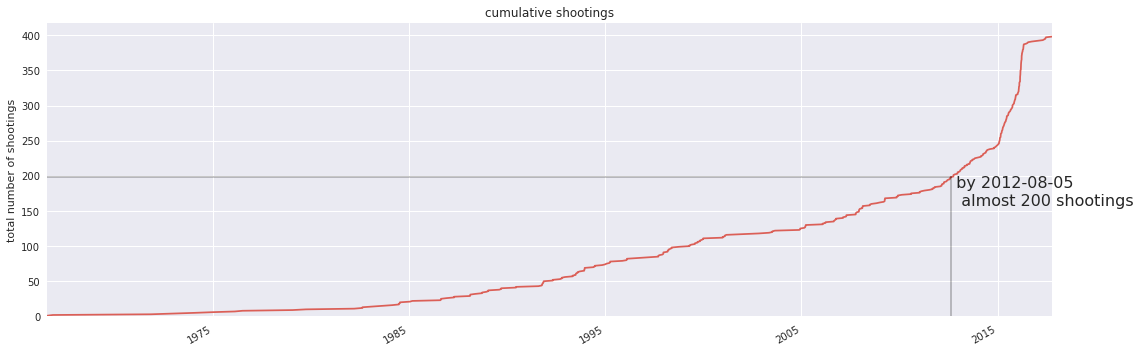

In [7]:
sn.set_palette('hls',8)
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'font.family':'DejaVu Sans'})
plt.figure(figsize=(18,6))
total.num_shootings.plot()
plt.plot([t_h,t_h],[0,df1.iloc[-1].num_shootings],'k-', alpha=.25)
plt.plot([df1.index[0],t_h],[df1.iloc[-1].num_shootings]*2,'k-', alpha=.25)
plt.text(t_h,df1.iloc[-1].num_shootings-40,' by %s \n  almost 200 shootings'%str(t_h)[:10])
a,b = plt.ylim()
plt.ylim(0,b)
plt.ylabel('total number of shootings')
plt.xlabel('');
plt.title('cumulative shootings');

In [8]:
#total[total.total_victims >= .5*total.total_victims.max()].head(1)

<br>
For the total number of victims (injured or dead) the halfway point is a year earlier in September 2011. The graph below shows the total number of victims in each year where there is a large spike in 2012. When we get to 2015 and on, each year has been more violent than the previous one.

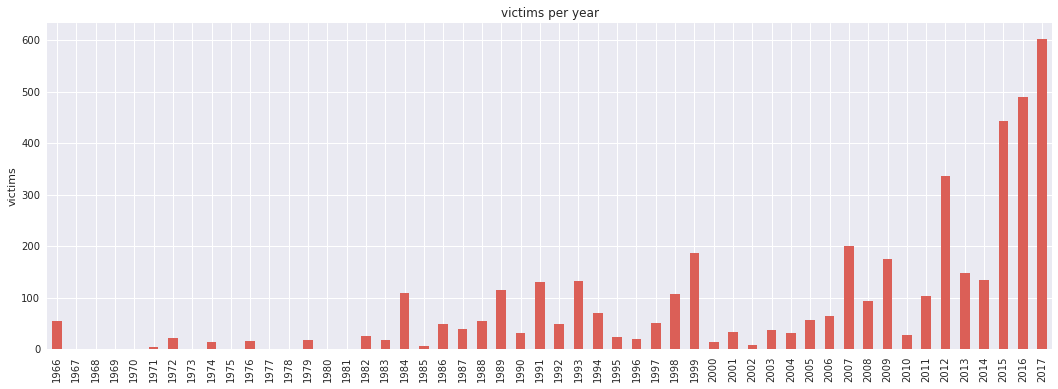

In [9]:
#how many deaths per year?
plt.figure(figsize=(18,6))

by_year = df.groupby(pd.Grouper(key='date',freq='AS'))['total_victims'].sum()

by_year.plot(kind='bar')

labels = [ str(x.year) for x in by_year.index]
plt.gca().set_xticklabels(labels);
plt.xlabel('');
plt.ylabel('victims')
plt.title('victims per year');

In [10]:
df['dt']= df.date - df.date.shift(-1) 
df['dt']=df.dt.dt.days

In [11]:
mask = df.date < t_h

In [12]:
df['period'] = mask
df['period'] = df.period.apply(lambda x: '1966 to 2012-08-05' if x else '2012-08-05 to 2017-10-01')

In [13]:
means = df.groupby('period')['dt','fatalities','total_victims'].mean()

<br>
How long do we have to wait to observer a new mass shooting? We could look at the entire dataset and just calculate the mean time between shootings, but the assumption gained from the above charts is that the rate of shootings is accelerating. Lets instead simply compare the mean time for the last five years roughly and the 46 years prior. This reveals a very alarming statistic, from 1966 to August 2012 there was a mass shooting, on average, every 86 days. However in the past five years the rate is almost 10 times faster, with an average of about 9 days. There might be some issues in the dataset, perhaps missed reporting, or something has seriously fallen apart over the last decade.

In [14]:
pd.DataFrame(means)

,dt,fatalities,total_victims
period,,,
1966 to 2012-08-05,86.102564,6.010204,12.311224
2012-08-05 to 2017-10-01,9.400990,4.049505,9.599010


In [15]:
x = np.arange(0,365,.1)

def exp_pdf(x,l):
    return l*np.exp(-x*l)

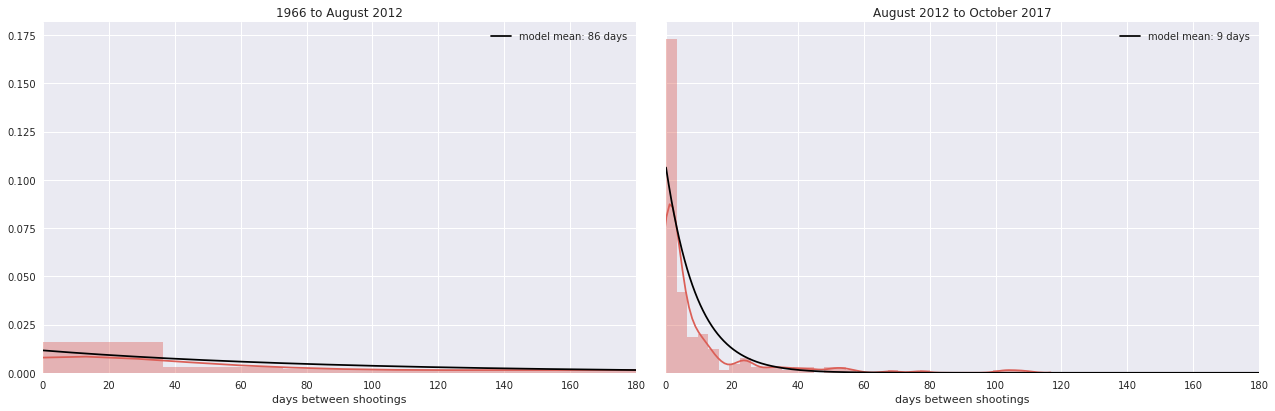

In [16]:

fig, axs = plt.subplots(1,2,sharey=True,figsize=(18,6))

sn.distplot(df[mask].dt.dropna(), hist=True, ax=axs[0])
mu = means.iloc[0]['dt']
axs[0].plot(x,exp_pdf(x,1/mu),'k-', label='model mean: %i days'%np.round(mu))
axs[0].set_xlim(0,180)
axs[0].legend()
axs[0].set_xlabel('days between shootings')

axs[0].set_title('1966 to August 2012')

sn.distplot(df[~mask].dt.dropna(), hist=True,ax = axs[1])
mu = means.iloc[1]['dt']
axs[1].plot(x,exp_pdf(x,1/mu), 'k-',label='model mean: %i days'%np.round(mu))
axs[1].set_xlim(0,180)
axs[1].legend()
axs[1].set_xlabel('days between shootings')
axs[1].set_title('August 2012 to October 2017')
plt.tight_layout();

In [17]:
df['year']= df.date.dt.year

In [18]:
#df['month'] = df.date.apply(lambda x: x.strftime('%B'))
df['month'] = df.date.dt.month

In [19]:
agg = df.groupby(['year','month'],as_index=False).num_shootings.sum()

In [22]:
piv = agg.pivot('month','year','num_shootings')
by_month = piv.sum(axis=1).copy() 
by_month/= by_month.sum()

In [23]:
piv.index = [calendar.month_name[x] for x in piv.index]

<br>
When looking at what month the shootings happen in, we can see that the first quarter of 2016 was the most violent and that largely because of that quarter, the months of February and March are the highest overall.

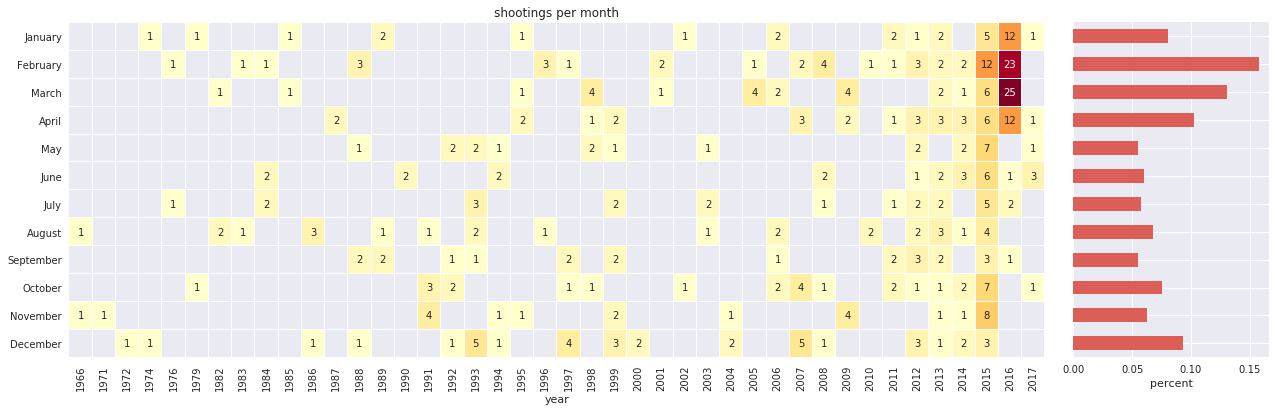

In [24]:
from matplotlib import gridspec

plt.figure(figsize=(18,6))

gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax0 = plt.subplot(gs[0])

sn.heatmap(piv, cmap="YlOrRd", linewidths=.01, annot=True,ax=ax0,cbar=False, annot_kws={"size": 10})
plt.title('shootings per month')

ax1 = plt.subplot(gs[1])

by_month.sort_index(ascending=False).plot(kind='barh',ax=ax1)
ax1.set_yticklabels([])
ax1.set_ylabel('')
ax1.set_xlabel('percent')
plt.tight_layout();

<br>
Overall the majority of attackers are male accounting for around 90% of attacks and outside of the relatively few male and female attacker cases, they are the most violent.

In [25]:
#by gender of attacker

df.gender.replace(['M','M/F'],['Male','Male/Female'], inplace=True)

#df.gender.value_counts()
df.gender.fillna('Unknown',inplace=True)

In [26]:
piv = df.pivot_table(['num_shootings','total_victims'], columns=['gender'], aggfunc=np.sum)
piv

gender,Female,Male,Male/Female,Unknown
num_shootings,7,363,5,23
total_victims,52,3541,83,676


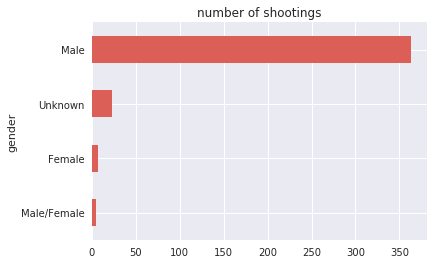

In [27]:
piv.transpose()['num_shootings'].sort_values().plot(kind='barh')
plt.title('number of shootings');

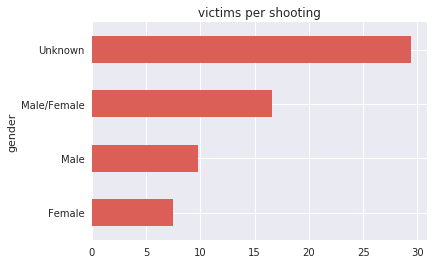

In [28]:
violence = piv.transpose().total_victims / piv.transpose().num_shootings
violence.plot(kind='barh')
plt.title('victims per shooting');

In [29]:
df.mental_health_issues.replace(['unknown','Unknown','Unclear '],['Unclear','Unclear','Unclear'],inplace=True)
df.mental_health_issues.fillna('Unclear',inplace=True)

<br>
When it comes to mental health the data is a little clearer, while lots of cases are not labeled, more than 50% of the classified cases indicate the attacker had a mental health issue. It is surprising this number isn't significantly higher and I would be interested to know more about the classification process used. 

In [30]:
piv = df.pivot_table(['num_shootings','total_victims'], columns=['mental_health_issues'], aggfunc=np.sum)
piv

mental_health_issues,No,Unclear,Yes
num_shootings,110,143,145
total_victims,811,1603,1938


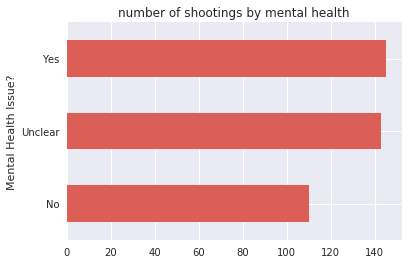

In [31]:
piv.transpose()['num_shootings'].sort_values().plot(kind='barh')
plt.title('number of shootings by mental health')
plt.ylabel('Mental Health Issue?');

<br>
We can also see that attackers with mental health issues seem to injure or kill more people, averaging about 13 victims per shooting versus 7 otherwise.

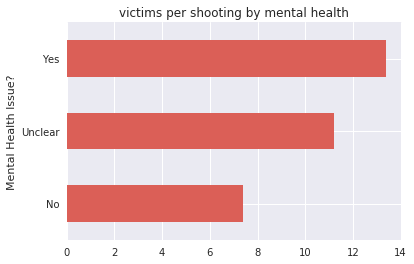

In [32]:
violence = piv.transpose().total_victims / piv.transpose().num_shootings
violence.plot(kind='barh')
plt.title('victims per shooting by mental health')
<brplt.ylabel('Mental Health Issue?');

<br>
### Geography

These shooting have happened all across the US with California having the most

In [ ]:
#first we geocode
import googlemaps
import os
from time import sleep
from tqdm import tqdm
GMAP_KEY = os.environ['GMAP_KEY']

In [905]:
gmaps = googlemaps.Client(key=GMAP_KEY)

In [49]:
#load the previous results
locations = pd.read_csv('data/geocode_results.csv')

In [50]:
locations = locations.to_dict(orient='records')
query_cache = dict([ (l['location'], l) for l in locations])
def parse_query_results(key):
    return query_cache[key]

In [940]:
query_cache={}

In [ ]:
for i,row in tqdm(df.iterrows(), total = len(df)):
    addr = row.location
    if addr in query_cache:
        continue

    try:
        r = gmaps.geocode(addr, components={'country':'US'})
        if r:
            query_cache[addr] = r
        sleep(.01)
    except Exception as e:
        print(e)

In [46]:
def parse_query_results(key):
    
    r = query_cache[key]
    
    k='long_name'
    comps={'location':key}
    for row in r[0]['address_components']:
        comps[row['types'][0]+'_long'] = row['long_name']
        comps[row['types'][0]+'_short'] = row['short_name']
        
    comps['lat'] = r[0]['geometry']['location']['lat']
    comps['lng'] = r[0]['geometry']['location']['lng']
    return comps

In [956]:
locations = pd.DataFrame( [parse_query_results(k) for k in query_cache])

In [947]:
locations.to_csv('data/geocode_results.csv',index=False)

In [1135]:
#locations.head(2).transpose()

In [51]:
df['state'] = df.location.apply(lambda x: parse_query_results(x).get('administrative_area_level_1_short',None))
df['county'] = df.location.apply(lambda x: parse_query_results(x).get('administrative_area_level_2_long',None))
df['city'] = df.location.apply(lambda x: parse_query_results(x).get('locality_long',None))
df['lat'] = df.location.apply(lambda x: parse_query_results(x).get('lat',None))
df['lng'] = df.location.apply(lambda x: parse_query_results(x).get('lng',None))

In [52]:
lats = df.lat.values
lngs = df.lng.values

In [53]:
#switch to bokeh for map stuffs
import bokeh.plotting as bk
bk.output_notebook();

Loading BokehJS ...

In [54]:
from pyproj import Proj, transform
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import Range1d, Label
from bokeh.tile_providers import CARTODBPOSITRON_RETINA
from bokeh.models import HoverTool

In [55]:
from_proj = Proj(init="epsg:4326")
to_proj = Proj(init="epsg:3857")

In [56]:
def trans(row):
    p = transform(from_proj, to_proj,row.lng, row.lat)
    return pd.Series({'x':p[0],'y':p[1]})

In [57]:
df = df.merge(df.apply(trans,axis=1),left_index=True, right_index=True)

In [59]:
x_range = Range1d(start=-15473429, end=2108550)
y_range = Range1d(start=0, end=7264686)

fig = figure(tools='pan, wheel_zoom,reset,hover', x_range=x_range, y_range=y_range, width=1000, height=500)

fig.axis.visible = False

fig.add_tile(CARTODBPOSITRON_RETINA)

source = ColumnDataSource(df[['x','y','date','city','state','summary','fatalities','total_victims']])

hover = fig.select(dict(type=HoverTool))
hover.tooltips =[
    ("summary", "@summary"),
]
hover.mode = 'mouse'


fig.circle('x','y',fill_color='red', size=7, alpha=.5, source = source)
bk.show(fig);

<br>
I would hope to see these trends reverse